<a href="https://colab.research.google.com/github/aryaar2004/CGIP-project--image-recognition/blob/main/image_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


In [ ]:
import tensorflow as tf

#DATASET_PATH = "/content/drive/MyDrive/PAWS/Dogs"  # Change this to your dataset folder

# Load dataset with train and validation split
training_set=tf.keras.utils.image_dataset_from_directory(
'/content/drive/MyDrive/Dog disease detection 1.v1i.folder/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bicubic",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

validation_set=tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/Dog disease detection 1.v1i.folder/valid',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=16,
    image_size=(224,224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bicubic",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,
)

# Split validation into test (10% validation, 10% test)
val_batches = tf.data.experimental.cardinality(validation_set)
test_dataset = validation_set.take(val_batches // 2)  # 10% test set
val_dataset = validation_set.skip(val_batches // 2)  # 10% validation set

print(f"Training set batches: {tf.data.experimental.cardinality(training_set).numpy()}")
print(f"Validation set batches: {tf.data.experimental.cardinality(val_dataset).numpy()}")
print(f"Test set batches: {tf.data.experimental.cardinality(test_dataset).numpy()}")


Found 3032 files belonging to 6 classes.
Found 860 files belonging to 6 classes.
Training set batches: 190
Validation set batches: 27
Test set batches: 27


In [ ]:
# Define paths
DATASET_PATH = "/content/drive/MyDrive/PAWS/Dogs"  # Change this to your dataset folder

# Create ImageDataGenerator for train & validation (80-20 split)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #horizontal_flip=True,
    #validation_split=0.2,
    fill_mode="nearest"# 20% for validation
)

val_datagen = ImageDataGenerator(rescale=1./255,
                                 #validation_split=0.2
                                 )

# Load dataset
batch_size = 16
img_size = (224, 224)

train_generator = train_datagen.flow_from_directory(
    "/content/drive/MyDrive/Dog disease detection 1.v1i.folder/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    "/content/drive/MyDrive/Dog disease detection 1.v1i.folder/valid",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)


Found 3032 images belonging to 6 classes.
Found 860 images belonging to 6 classes.


In [ ]:
#Resnet model

for images, labels in training_set.take(1):  # Take one batch
    num_classes = labels.shape[1]  # Number of classes is the second dimension of labels
    break

# Load pre-trained ResNet50 without the top layer
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers (don't train them initially)
base_model.trainable = False

# Custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(num_classes, activation="softmax")(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)


In [ ]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,340,358 (8.93 MB)

 Trainable params: 82,374 (321.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# After initial training, unfreeze last few layers
for layer in base_model.layers[-20:]:  # Unfreezing last 20 layers
    layer.trainable = True

# Use lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
epochs = 50

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stopping,lr_scheduler,checkpoint]
)


Epoch 1/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.6715 - loss: 1.1961
Epoch 1: val_loss did not improve from 0.46251
190/190 ━━━━━━━━━━━━━━━━━━━━ 78s 339ms/step - accuracy: 0.6718 - loss: 1.1942 - val_accuracy: 0.8047 - val_loss: 0.6841 - learning_rate: 1.0000e-04
Epoch 2/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7980 - loss: 0.5749
Epoch 2: val_loss did not improve from 0.46251
190/190 ━━━━━━━━━━━━━━━━━━━━ 54s 286ms/step - accuracy: 0.7981 - loss: 0.5748 - val_accuracy: 0.8488 - val_loss: 0.4975 - learning_rate: 1.0000e-04
Epoch 3/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8168 - loss: 0.5200
Epoch 3: val_loss did not improve from 0.46251
190/190 ━━━━━━━━━━━━━━━━━━━━ 55s 288ms/step - accuracy: 0.8169 - loss: 0.5199 - val_accuracy: 0.8430 - val_loss: 0.5120 - learning_rate: 1.0000e-04
Epoch 4/50
190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8459 - loss: 0.4415
Epoch 4: val_loss did not improve from 0.46251
190/190 ━━━━━━━━

In [ ]:
from tensorflow.keras.utils import Sequence

class MyDataset(Sequence):
    def __init__(self, X, y, **kwargs):
        super().__init__(**kwargs)  # ✅ Fix: Call parent class constructor
        self.X = X
        self.y = y


In [ ]:
del model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 as base model (excluding top layers)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

# Freeze the base model so it doesn’t lose its pretrained features
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
output_layer = Dense(6, activation="softmax")(x)

# Create model
model = Model(inputs=base_model.input, outputs=output_layer)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping # This line imports the EarlyStopping callback from Keras. Early stopping helps prevent overfitting by stopping the training process when the model's performance on a validation set stops improving.

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True,min_delta=0.001)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau # Import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint # Import ModelCheckpoint

checkpoint_path = 'model_checkpoints/SkinDisease.weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

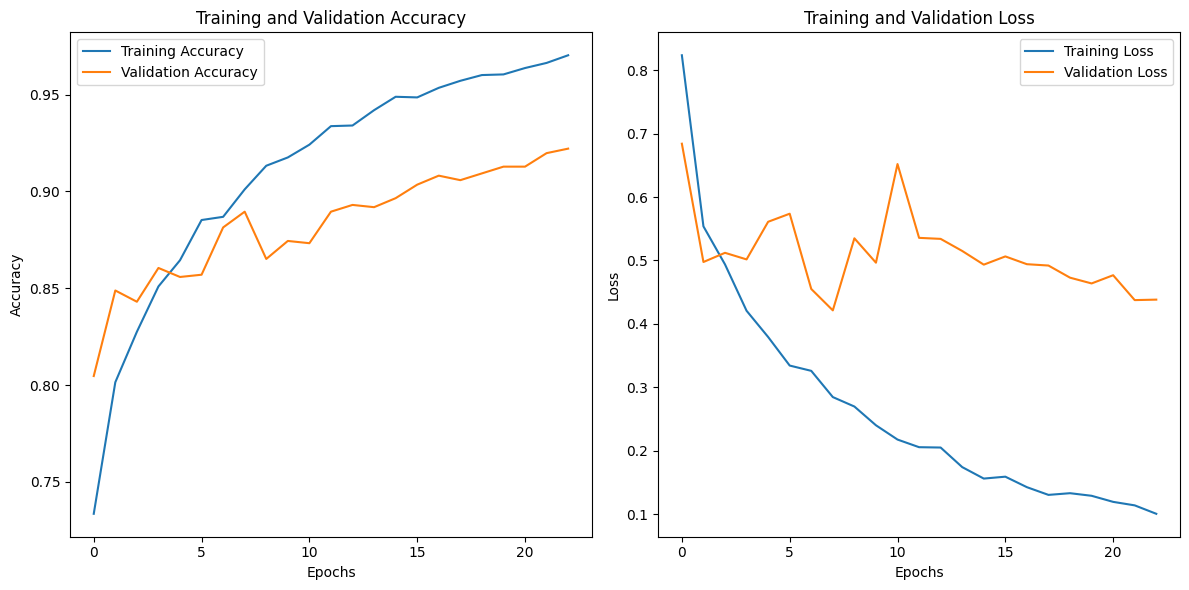

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'training_zccuracy' is the object returned by model.fit()
# training_zccuracy.history contains accuracy and loss values for each epoch

# Plotting training and validation accuracy
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Training Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
TEST_DIR = "/content/drive/MyDrive/Dog disease detection 1.v1i.folder/test"
test_datagen = ImageDataGenerator(rescale = 1.0 / 255. )

# pass in the appropriate arguments to the flow_from_directory method
test_set_2 = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                      batch_size=16,
                                                      class_mode='categorical',
                                                      target_size=(224, 224))

Found 433 images belonging to 6 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)  # Match training preprocessing

test_generator = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/Dog disease detection 1.v1i.folder/test",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False  # Keep order for correct evaluation
)


Found 433 images belonging to 6 classes.


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("PAWS_model1.keras")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
import numpy as np

Y_pred_2 = model.predict(test_generator)
y_pred_2 = np.argmax(Y_pred_2, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 82s 6s/step


In [ ]:
history.history

{'accuracy': [0.7335092425346375,
  0.8014512062072754,
  0.8275066018104553,
  0.850923478603363,
  0.8644459247589111,
  0.8852242827415466,
  0.8868733644485474,
  0.9010553956031799,
  0.9132585525512695,
  0.9175461530685425,
  0.9241424798965454,
  0.9337071180343628,
  0.934036910533905,
  0.9419525265693665,
  0.9488786458969116,
  0.9485487937927246,
  0.9534960389137268,
  0.9571239948272705,
  0.9600923657417297,
  0.960422158241272,
  0.9637203216552734,
  0.9663588404655457,
  0.9703166484832764],
 'loss': [0.8235468864440918,
  0.553749680519104,
  0.49375858902931213,
  0.42065533995628357,
  0.3793104588985443,
  0.3342457413673401,
  0.3258954584598541,
  0.28454217314720154,
  0.269651859998703,
  0.2400738149881363,
  0.2175522893667221,
  0.20551978051662445,
  0.204972043633461,
  0.17412112653255463,
  0.1560375690460205,
  0.15901759266853333,
  0.14247222244739532,
  0.13030597567558289,
  0.1329718828201294,
  0.12889626622200012,
  0.11930536478757858,
  0.113

In [ ]:
from tensorflow.keras.utils import Sequence

class MyDataset(Sequence):
    def __init__(self, X, y):
        self.X = X
        self.y = y


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, y_pred_2))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85        66
           1       0.89      0.74      0.81        54
           2       0.88      0.94      0.91        69
           3       0.93      0.90      0.91        29
           4       0.97      0.97      0.97       100
           5       0.95      0.92      0.94       115

    accuracy                           0.91       433
   macro avg       0.90      0.90      0.90       433
weighted avg       0.91      0.91      0.91       433



In [ ]:
train_loss,train_acc=model.evaluate(training_set)

190/190 ━━━━━━━━━━━━━━━━━━━━ 144s 740ms/step - accuracy: 0.1900 - loss: 8.3205


In [ ]:
val_loss,val_acc=model.evaluate(validation_set)

54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 827ms/step - accuracy: 0.2137 - loss: 7.6798


In [ ]:
model.save("PAWS_model.h5")

In [ ]:
model.save('PAWS.keras')

In [ ]:
import json
with open('training_history.json', 'w') as f:
    json.dump(history.history, f)

In [ ]:
def predict_image(image_upload, model = model):
  im = image_upload
  im_array = np.asarray(im)
  im_array = im_array*(1.0/225.)
  im_input = tf.reshape(im_array, shape = [1, 224, 224, 3])

  predict_array = model.predict(im_input)[0]

  import pandas as pd
  df = pd.DataFrame(predict_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  prod = ['Dermatitis', 'Fungal_infection', 'Healthy','Hypersensitivity','demodicosis', 'ringworm']
  df['Animal'] = prod
  df = df[['Animal', 'Probability']]

  predict_label = np.argmax(model.predict(im_input))

  if predict_label == 0:
      predict_product = 'Dermatitis'
  elif predict_label == 1:
      predict_product = 'Fungal_infection'
  elif predict_label == 2:
      predict_product = 'Healthy'
  elif predict_label == 3:
      predict_product = 'Hypersensitivity'
  elif predict_label == 4:
      predict_product = 'demodicosis'
  else:
      predict_product = 'ringworm'

  return predict_product, df

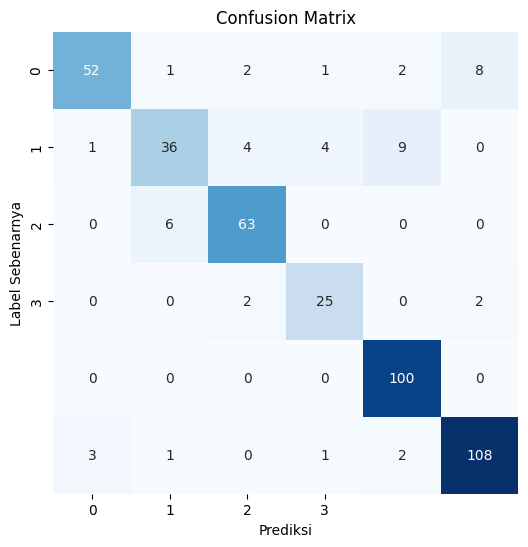

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_true = test_generator.classes  # Label yang sebenarnya
y_pred = y_pred_2  # Label prediksi

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix dalam bentuk heatmap
class_names = ['0', '1', '2', '3']  # Nama kelas (sesuaikan dengan kelas Anda)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Label Sebenarnya')
plt.title('Confusion Matrix')
plt.show()

Saving images (1).jpeg to images (1) (1).jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step




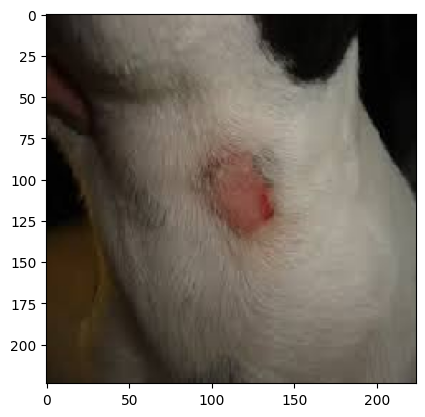


The image is detected as ringworm


             Animal   Probability
0        Dermatitis  3.103245e-02
1  Fungal_infection  6.487749e-07
2           Healthy  2.594011e-08
3  Hypersensitivity  1.326351e-06
4       demodicosis  1.602558e-09
5          ringworm  9.689655e-01




In [ ]:
from keras.preprocessing import image
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  path = fn
  img = tf.keras.preprocessing.image.load_img(path, target_size=(224,224))
  imgplot = plt.imshow(img)
  x = tf.keras.preprocessing.image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  img = np.vstack([x])

label, df = predict_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/content/drive/MyDrive/PAWS.keras")

# Verify the model architecture
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 4,917,268 (18.76 MB)

 Trainable params: 1,288,454 (4.92 MB)

 Non-trainable params: 1,051,904 (4.01 MB)

 Optimizer params: 2,576,910 (9.83 MB)

In [ ]:
import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/PAWS.keras')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optional: Optimize for size/speed
tflite_model = converter.convert()

# Save TFLite model
with open('PAWS.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model successfully converted to TFLite!")


Saved artifact at '/tmp/tmpsxahb4tp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135953150083344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150087952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150084880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150088336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150087376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150086800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150089872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150090064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150089296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135953150083536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1359531500912